### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Read in Raw file

In [2]:
# File path for ETH‑USD minute data
ethusd_file_path = "../../data/raw/minute/ethusd.csv"

In [3]:
# Load the minute-level data
data = pd.read_csv(ethusd_file_path)

# Convert Unix Timestamp (milliseconds) to datetime (keeping it as a column)
data['time'] = pd.to_datetime(data['time'], unit='ms')

# Sort by time
data = data.sort_values('time')

# Set 'time' as index temporarily to resample
data = data.set_index('time')

# Check the data
data.head()

,open,close,high,low,volume
time,,,,,
2016-03-09 16:04:00,10.297,10.097,10.297,10.097,0.03
2016-03-09 17:49:00,11.197,11.197,11.197,11.197,0.01
2016-03-09 18:56:00,11.097,11.097,11.097,11.097,0.02
2016-03-09 20:16:00,11.195,11.195,11.195,11.195,0.01
2016-03-09 20:21:00,10.870,10.870,10.870,10.870,1.00


#### Checking No. of obs per day

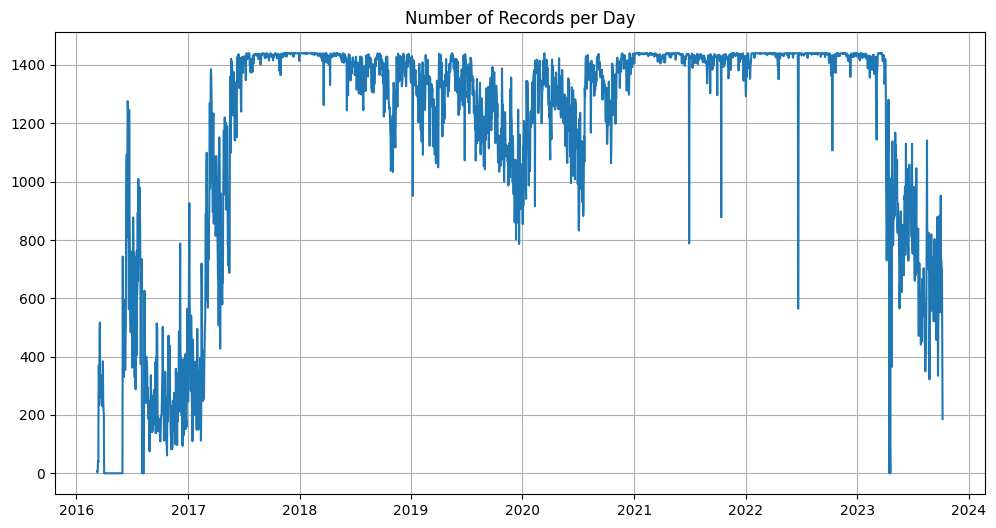

In [4]:
# Calculate number of records per day
count = data['open'].resample('1D').apply(lambda x: x.count())

# Plot the number of records per day
plt.figure(figsize=(12, 6))
plt.plot(count)
plt.title('Number of Records per Day')
plt.grid()
plt.show()

In [5]:
# find where count is zero
zero_count = count[count == 0].index
zero_count

DatetimeIndex(['2016-04-01', '2016-04-02', '2016-04-03', '2016-04-04',
               '2016-04-05', '2016-04-06', '2016-04-07', '2016-04-08',
               '2016-04-09', '2016-04-10', '2016-04-11', '2016-04-12',
               '2016-04-13', '2016-04-14', '2016-04-15', '2016-04-16',
               '2016-04-17', '2016-04-18', '2016-04-19', '2016-04-20',
               '2016-04-21', '2016-04-22', '2016-04-23', '2016-04-24',
               '2016-04-25', '2016-04-26', '2016-04-27', '2016-04-28',
               '2016-04-29', '2016-04-30', '2016-05-01', '2016-05-02',
               '2016-05-03', '2016-05-04', '2016-05-05', '2016-05-06',
               '2016-05-07', '2016-05-08', '2016-05-09', '2016-05-10',
               '2016-05-11', '2016-05-12', '2016-05-13', '2016-05-14',
               '2016-05-15', '2016-05-16', '2016-05-17', '2016-05-18',
               '2016-05-19', '2016-05-20', '2016-05-21', '2016-05-22',
               '2016-05-23', '2016-05-24', '2016-05-25', '2016-05-26',
      

#### Dropping days prior to Jun-16 and days without transactions

In [6]:
# Drop records earlier than 2016-06-01
data = data.loc[data.index >= '2016-06-01']

# Drop records where count is zero
data = data.loc[~data.index.normalize().isin(zero_count)]

### Compute intraday log returns and daily RV

In [7]:
# Calculate intraday log returns
data['Log Return'] = np.log(data['close'] / data['close'].shift(1))

# Drop records with missing log returns (the first record)
data.dropna(subset=['Log Return'], inplace=True)

In [8]:
# Calculate daily realized variance from log returns
rv_1d = data['Log Return'].resample('1D').apply(lambda x: np.sum(x**2))

# Normalise the realized variance by the number of intraday returns
count_1 = data['Log Return'].resample('1D').apply(lambda x: x.count())
rv_1d /= count_1

In [9]:
# Aggregate minute data into daily data:
daily_data = data.resample('1D').agg({
    'open': 'first',        # First open price of the day
    'close': 'last',        # Last close price of the day
    'high': 'max',          # Highest price of the day
    'low': 'min',           # Lowest price of the day
    'volume': 'sum',        # Total volume for the day
})

# Add daily realized variance and rename the column
daily_data['1D RV'] = rv_1d
daily_data.rename(columns={'1D RV': 'RV_d,t'}, inplace=True)

# Add number of records per day
daily_data['count'] = count_1

In [10]:
# Calculate daily returns from the daily close price
daily_data['daily_return'] = daily_data['close'].pct_change(fill_method=None)

# Drop records with missing daily returns (the first record)
daily_data.dropna(subset=['daily_return'], inplace=True)

# Normalise RV by the number of intraday returns, we are expecting 1440 a day
daily_data['RV_d,t'] *= 1440

In [11]:
daily_data.head()

,open,close,high,low,volume,"RV_d,t",count,daily_return
time,,,,,,,,
2016-06-02,13.940,13.770,14.029,13.608,45433.303588,0.008598,426,-0.012549
2016-06-03,13.818,13.940,13.990,13.420,57902.825013,0.010071,564,0.012346
2016-06-04,13.940,13.701,13.962,13.404,40804.625605,0.007276,430,-0.017145
2016-06-05,13.787,13.895,13.969,13.686,16549.050051,0.006964,330,0.014160
2016-06-06,13.970,13.949,14.193,13.801,33303.742772,0.007994,425,0.003886


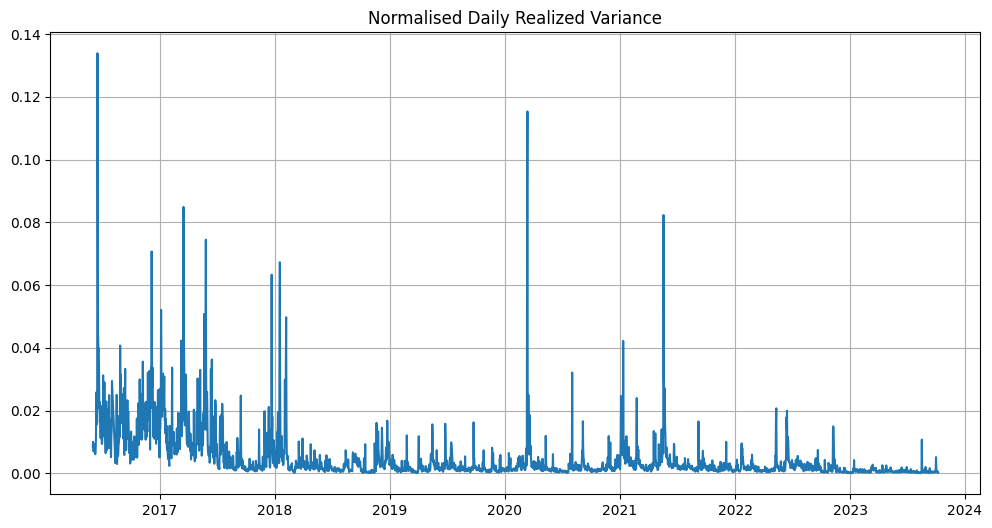

In [12]:
# Plot the daily realized variance
plt.figure(figsize=(12, 6))
plt.plot(daily_data['RV_d,t'])
plt.title('Normalised Daily Realized Variance')
plt.grid()
plt.show()

In [13]:
# Compute rolling averages for realized variance: 7-day and 30-day
daily_data['RV_w,t'] = daily_data['RV_d,t'].rolling(window=7).mean()
daily_data['RV_m,t'] = daily_data['RV_d,t'].rolling(window=30).mean()

# Apply logarithmic transformation to the realized variance measures
daily_data['ln_RV_d,t'] = np.log(daily_data['RV_d,t'])
daily_data['ln_RV_w,t'] = np.log(daily_data['RV_w,t'])
daily_data['ln_RV_m,t'] = np.log(daily_data['RV_m,t'])

# Reset the index so that 'time' becomes a column again
daily_data = daily_data.reset_index()

### Parkinson Volatility values

In [14]:
def calculate_parkinson(data, window):
    """
    Calculate Parkinson Volatility using high and low prices over a rolling window.
    Haven't found a use for this yet.
    
    Parameters:
    - data: DataFrame with 'High' and 'Low' columns.
    - window: Rolling window size for Parkinson Volatility (e.g., 7 or 30 days).
    
    Returns:
    - Series containing Parkinson Volatility values.
    """
    parkinson_vol = np.sqrt(
        (1 / (4 * np.log(2) * window)) *
        (np.log(data['High'] / data['Low']) ** 2).rolling(window=window).sum()
    )
    return parkinson_vol


# 2. Fred MD data
We will be using the **PublicDataReader** package to pull Fred MD data. You will need to use the FRED API key which can be obtained [here](https://fredaccount.stlouisfed.org/apikey). Store the API key as a local variable using .env file

## 2.1 Creating .env and pulling data
Uncomment the code and put it in the .env file

In [ ]:
# FRED_API="your_fred_api_key_here"

### Download the full dataset from Fred MD

In [15]:
import os
import io
import requests
from dotenv import load_dotenv

In [16]:
# Load API Key
load_dotenv()
api_key = os.getenv("FRED_API")

# Download the full dataset
fred_md_url = "https://files.stlouisfed.org/files/htdocs/fred-md/monthly/current.csv"

response = requests.get(fred_md_url)

# Need to use io.StringIO
df = pd.read_csv(io.StringIO(response.content.decode('utf-8')))

# Too many white spaces in the column names
df.columns = df.columns.str.strip()

# Convert 'sasdate' to datetime
df["sasdate"] = pd.to_datetime(df["sasdate"], errors="coerce")

# Remove the sasdate rows with NaT
df = df.dropna(subset=["sasdate"])

# Remove the sasdate rows that are not dates
df = df[df["sasdate"].dt.year > 1960]


/var/folders/cx/mjdsxp6x367bkv2wc28scrt80000gn/T/ipykernel_4504/3848825664.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["sasdate"] = pd.to_datetime(df["sasdate"], errors="coerce")


### Merge the datasets and then save

In [17]:
daily_data['month_year'] = pd.to_datetime(daily_data['time']).dt.to_period('M')
df['month_year'] = df['sasdate'].dt.to_period('M')

# Merge the data using the helper column 'month_year'
merged_data = pd.merge(daily_data, df, on='month_year', how='inner')

# Drop the helper column 'month_year'
merged_data.drop(columns='month_year', inplace=True)

# Drop sasdate column (Repeated with time column)
merged_data.drop(columns='sasdate', inplace=True)

# Save the merged data to a CSV file
merged_data.to_csv("../../data/ethusd_group_project.csv", index=False)


# Feature Selection

In [18]:
data = pd.read_csv("../../data/ethusd_group_project.csv")

# Lag the daily, weekly, and monthly rv measures by one day
data['ln_RV_d,t-1'] = data['ln_RV_d,t'].shift(1)
data['ln_RV_w,t-1'] = data['ln_RV_w,t'].shift(1)
data['ln_RV_m,t-1'] = data['ln_RV_m,t'].shift(1)

# Do it for the non-logarithmic RV measures as well
data['RV_d,t-1'] = data['RV_d,t'].shift(1)
data['RV_w,t-1'] = data['RV_w,t'].shift(1)
data['RV_m,t-1'] = data['RV_m,t'].shift(1)


In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

# exclude warnings
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv("../../data/ethusd_group_project.csv")

data = data.dropna()
# Also exclude the lagged RV measures
to_exclude = ['time', 'ln_RV_d,t', 'ln_RV_w,t', 'ln_RV_m,t', 'RV_d,t', 'RV_w,t', 'RV_m,t']
features = [col for col in data.columns if col not in to_exclude]  # Exclude time & target
X = data[features].values
y = data['ln_RV_d,t'].values  # Predicting next day's realized variance

# Standardize Features
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Apply LASSO Regression with Cross-Validation
lasso = LassoCV(
    alphas=np.logspace(-5, 1, 50), 
    cv=5, 
    max_iter=10000,  
    tol=1e-4,  
    random_state=42
).fit(X_scaled, y_scaled)

print(lasso.coef_)
# Select Important Features
selected_features = np.array(features)[lasso.coef_ != 0]  # Keep non-zero coefficients
print(f"Selected {len(selected_features)} features: {selected_features}")

# Create a New Dataset with Selected Features
data_selected = data[to_exclude + list(selected_features)]
data_selected.to_csv("../../data/ethusd_lasso_selected.csv", index=False)

print("Feature selection complete! Saved dataset with important features.")

[-0.         -0.         -0.         -0.          0.1651172  -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.          0.          0.          0.          0.          0.
  0.         -0.          0.          0.00158082  0.         -0.
  0.         -0.         -0.         -0.         -0.         -0.
 -0.          0.00076843  0.         -0.         -0.         -0.
  0.         -0.         -0.         -0.         -0.         -0.28181446
 -0.         -0.         -0.         -0.         -0.         -0.
  0.         -0.          0.          0.          0.          0.
 -0.          0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.          0.         -0.          0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.01936571 -0.
 -0.          0.         -0.          0.          0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
  0.         -0. 